# Test trained model(s)

In [1]:
######################################
#Script to test and log trained model#
#Maintainer: Christopher CHan        #
#Version: 0.2.2                      #
#Date: 2022-03-06                    #
######################################

import os
import sys
import torch
import random
import re
import tqdm
from dataloader import BuildingDataset
import numpy as np
import torchvision.models as models
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from Networks import Five_UNet, Four_UNet
from torchvision import transforms
from PIL import Image
%matplotlib inline


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/")

td_KBY = os.path.join(data_path, "td_KBY")
td_DZK = os.path.join(data_path, "td_DZK")
td_DZKN = os.path.join(data_path, "td_DZKN")


In [2]:
# Prespare sample dataloader
def tvt_split(td):
    
    img_ls = []
    
    for root, dirs, filename in os.walk(os.path.join(td, "IMG")):
        for i in filename:
            if i.endswith(".png"):
                img_ls.append(root + "/" + i)
        
        img_ls = BuildingDataset(img_ls, _)
        
        train_IMG, val_IMG, test_IMG = random_split(img_ls.png_dir, [int(round(0.0 * len(img_ls.png_dir))),
                                                                     int(round(0.0 * len(img_ls.png_dir))),
                                                                     int(round(1.0 * len(img_ls.png_dir)))])
        
        return train_IMG, val_IMG, test_IMG

DZK_train, DZK_val, DZK_test = tvt_split(td_DZK)
KBY_train, KBY_val, KBY_test = tvt_split(td_KBY)
DZKN_train, DZKN_val, DZKN_test = tvt_split(td_DZKN)

TestLBL_ls = []

TestIMG_ls = list(DZK_test + KBY_test + DZKN_test)

for i in TestIMG_ls:
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

Test = BuildingDataset(png_dir = TestIMG_ls,
                       lbl_dir = TestLBL_ls)

assert len(Test.png_dir) == len(Test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(Test.png_dir)))
for x, y in zip(Test.png_dir, Test.lbl_dir):
    print(f"Image: {x}", f"Label: {y}")


Concatenated TESTING images: 30 and labels pair: 30 :
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/IMG/DZK10_IMG_1705-5456.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/LBL/DZK10_LBL_1705-5456.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/IMG/DZK10_IMG_1705-5797.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/LBL/DZK10_LBL_1705-5797.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/IMG/DZK10_IMG_1364-5456.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/LBL/DZK10_LBL_1364-5456.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/IMG/DZK10_IMG_1705-5115.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/LBL/DZK10_LBL_1705-5115.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/IMG/DZK10_IMG_1705-4774.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/LBL/DZK10_LBL_1705-4774.png
Image: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/IMG/DZK10_IMG_1705-4433.png Label: /home/chris/Dropbox/HOTOSM/SAMPLE/td_DZK/LBL/DZK10_LBL_1705-4433.png
Image: /home/chris/Dropbox/HOTOSM/

Text(0.5, 1.0, 'LBL')

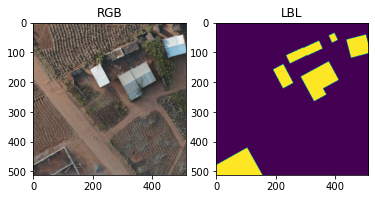

In [3]:
# plot a sample
test_pair = random.choice(Test)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')


### Qubvel OpenCities U-Net

In [4]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)

qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(qubvelEB1_UNet)
print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
<class 'torch.Tensor'>
torch.Size([1, 1, 512, 512]) torch.Size([1, 512, 512])


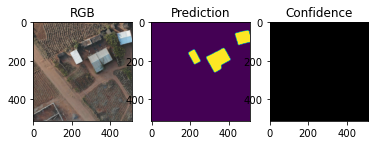

In [5]:
qubvelEB1_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img.to(device = device)
lbl.to(device = device)
print(img.shape, lbl.shape)
print(type(img))

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    confidence = torch.argmax(prediction, 1)

print(prediction.shape, confidence.shape)

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 3, 2)
pred = plt.imshow(prediction.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('Prediction')

ax = fig.add_subplot(1, 3, 3)
conf = plt.imshow(confidence.detach().cpu().numpy().transpose(1, 2, 0), cmap = "nipy_spectral")
#plt.colorbar(ticks = [0.1, 0.3, 0.5, 0.7], orientation = "vertical")
ax.set_title('Confidence')

# Testing a batch of 30

# Pass the test set through
test_loader = DataLoader(Test, batch_size = 1, shuffle = True)
#test_results = []

#for i, (imgs, labels) in enumerate(test_loader):
#    imgs = imgs.to(device = device, dtype = torch.float32)
#    labels = labels.to(device = device, dtype = torch.float32)
#
#    test_prediction = qubvelEB1_UNet(imgs)
#    test_results.append(test_prediction)

### Vanilla Four layer UNet Baseline

In [6]:
Four_UNet = Four_UNet()
weights_4UNet = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/1734:867oc1_FourUNET_Adam1e-3_wd1e-3_b8_ep500_BCE_iter_067486.pth")
weights_4UNet = torch.load(weights_4UNet, map_location = device)
Four_UNet.load_state_dict(weights_4UNet["Model:"])
Four_UNet.to(device = device)

print(Four_UNet)
print(sum(p.numel() for p in Four_UNet.parameters() if p.requires_grad == True))

Four_UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
<class 'torch.Tensor'>
torch.Size([1, 1, 512, 512]) torch.Size([1, 512, 512])


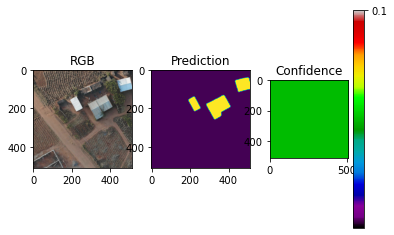

In [7]:
Four_UNet.eval()

# Testing a single pair of Image and Label

img, lbl = test_pair[0], test_pair[1]
img.to(device = device)
lbl.to(device = device)
print(img.shape, lbl.shape)
print(type(img))

with torch.no_grad():
    prediction = qubvelEB1_UNet(img.unsqueeze(0))
    confidence = torch.argmax(prediction, 1)

print(prediction.shape, confidence.shape)

# Plotting the RGB, Prediction, and Confidence
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
RGB = plt.imshow(test_pair[0].detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 3, 2)
pred = plt.imshow(prediction.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0))
ax.set_title('Prediction')

ax = fig.add_subplot(1, 3, 3)
conf = plt.imshow(confidence.detach().cpu().numpy().transpose(1, 2, 0), cmap = "nipy_spectral")
plt.colorbar(ticks = [0.1, 0.3, 0.5, 0.7], orientation = "vertical")
ax.set_title('Confidence')

# Testing a batch of 30

# Pass the test set through
test_loader = DataLoader(Test, batch_size = 1, shuffle = True)
#test_results = []

#for i, (imgs, labels) in enumerate(test_loader):
#    imgs = imgs.to(device = device, dtype = torch.float32)
#    labels = labels.to(device = device, dtype = torch.float32)
#
#    test_prediction = qubvelEB1_UNet(imgs)
#    test_results.append(test_prediction)